<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/7.Controller-tuning/Sintonia_de_controladores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar e importas as bibliotecas necessárias

In [7]:
! pip install -qq control

In [12]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Identificar o modelo do processo

Considere um problema em que a corrente de um processo deve ser aquecida usando um trocador de calor de casco e tubo. A temperatura de saída é controlada ajustando a válvula de vapor.

Durante um teste experimental em malha aberta, a pressão do vapor Ps foi alterada repentinamente de 18 a 20 psi e foram obtidos os dados de temperatura na tabela de dados experimentais.

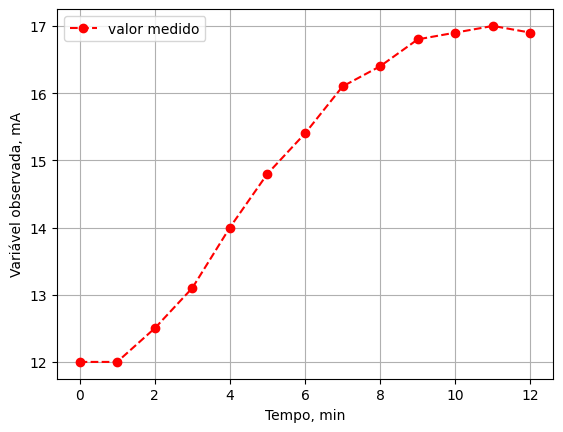

In [11]:
# Dados experimentais
t = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
T_2m = np.array([12, 12, 12.5, 13.1, 14, 14.8, 15.4, 16.1, 16.4, 16.8, 16.9, 17, 16.9])

plt.figure(1)
plt.plot(t,T_2m, '--or', label = 'valor medido')
plt.xlabel('Tempo, min')
plt.ylabel('Variável observada, mA')
plt.legend()
plt.grid()

## Identificação do processo segundo Sundaresan e Krishnaswamy

In [ ]:
Delta_Ps = 20-18
Delta_T2m = 17-T_2m[0]

t1 =  # 35.3% de Delta_T2m
t2 =  # 85.3% de Delta_T2m

theta = 1.3*t1 - 0.29*t2
tau = 0.67*(t2-t1)
Kp =  Delta_T2m/Delta_Ps
print('\nProcesso: Kp = %1.3f  tau = %1.3f  theta = %1.3f' %(Kp, tau, theta))


## Validar o modelo identificado

In [ ]:
# Implementar o modelo
s = ct.tf('s')
Gtd = ct.tf(*ct.pade(theta,5,3))
Gp = Kp/(tau*s+1)*Gtd

# Testar o modelo na mesma condição dos dados
tval, yval = ct.step_response(Gp,T=t)
Tval = Delta_Ps*yval + T_2m[0]
print('Qualidade do modelo -> R-quadrado = %1.2f' %r2_score(T_2m, Tval) )

yval,tval = ct.step_response(Gp,T=t[-1])
plt.plot(tval, Delta_Ps*yval + T_2m[0] , label='valor predito')

plt.xlabel('tempo, min')
plt.ylabel(r'$T_{2m}$, mA')
plt.legend()
plt.tight_layout()
plt.show()

# Ajuste dos parâmetros do controlador

In [12]:
# Sistema a ser controlado
Kv = 0.9
Kip = 0.75
G = Kv*Kip*Gp # Gtil
K = G.dcgain()
print('\nSistema: K = %1.3f  tau = %1.3f  theta = %1.3f' %(K, tau, theta))


# sintonia IMC
tau_c = theta # Skogestad

# Sintonias dos controladores
## IMC

## ITAE


# Simulação da malha fechada



# Análise dos resultados